Number of events detected: 44
Skipping event 0 due to error: object of type 'NoneType' has no len()
Skipping event 1 due to error: object of type 'NoneType' has no len()
Skipping event 2 due to error: object of type 'NoneType' has no len()
Skipping event 5 due to error: could not broadcast input array from shape (14,) into shape (0,)
Skipping event 9 due to error: could not broadcast input array from shape (31,) into shape (0,)
Skipping event 13 due to error: could not broadcast input array from shape (69,) into shape (0,)
Skipping event 15 due to error: could not broadcast input array from shape (71,) into shape (0,)
Skipping event 17 due to error: could not broadcast input array from shape (75,) into shape (0,)
Skipping event 20 due to error: could not broadcast input array from shape (96,) into shape (0,)
Skipping event 21 due to error: negative dimensions are not allowed
Skipping event 27 due to error: could not broadcast input array from shape (136,) into shape (0,)
Skipping event

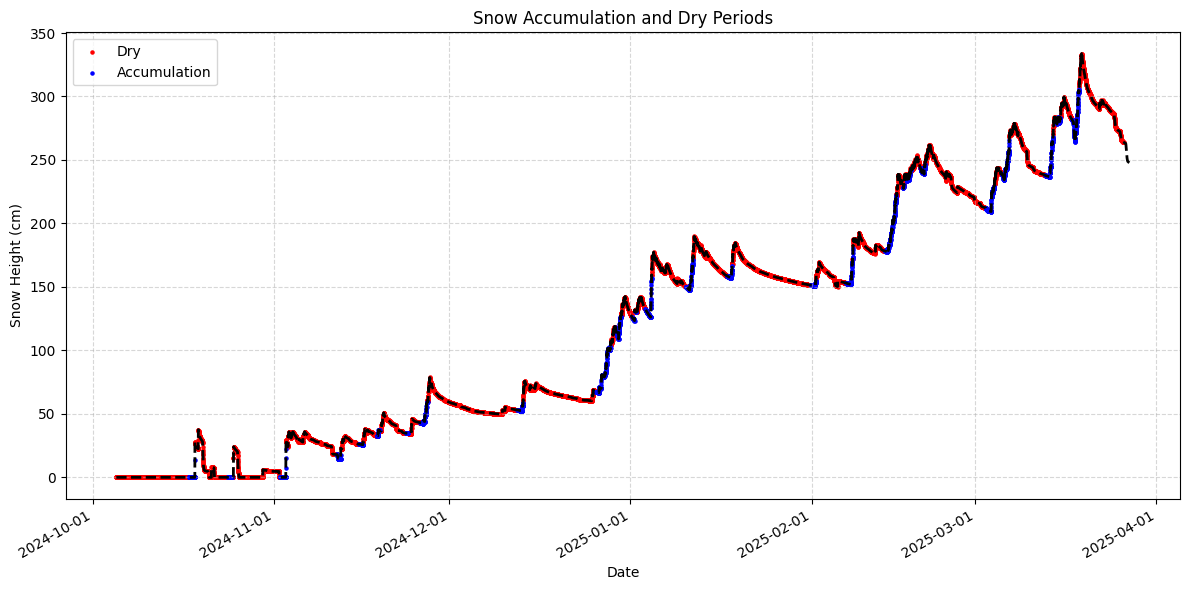

In [6]:
# main.py

from config import PRO_FILE
from data_loader import load_profile, extract_variables
from utils import compute_hst, identify_accumulation_periods, track_layers,get_number_events, track_all_layers_xr,parse_gtype, identify_accumulation_periods_old
from plotting import plot_hst_and_periods, plot_seasonal_sn38
import matplotlib.pyplot as plt

pro = load_profile(PRO_FILE)
vars = extract_variables(pro)

hst = compute_hst(vars['ht'])
dry_indices, accum_indices = identify_accumulation_periods_old(hst)

plot_hst_and_periods(vars['dates'], hst, dry_indices, accum_indices)
num_events, accum_end_index =get_number_events(accum_indices)
print(f"Number of events detected: {num_events}")

#ds = track_layers(accum_indices, accum_end_index, 0, vars['id'], vars['rcl'], vars['gt'], vars['rho'], vars['sn38'], vars['ht'], vars['dates'])

ds_all = track_all_layers_xr(accum_indices, accum_end_index, vars['id'], vars['rcl'], vars['gt'], vars['rho'], vars['sn38'],vars['shear_strength'],vars['ht'], vars['dates'])



[ 3  4  6  7  8 10 11 12 14 16 18 19 22 23 24 25 26 28 30 31 32 33 34 36
 38 39 40 41 42 43]
(12958,)
(30, 12958, 24)
[ nan  nan  nan ... 330. 330. 330.]
[nan nan nan ...  3.  3.  3.]


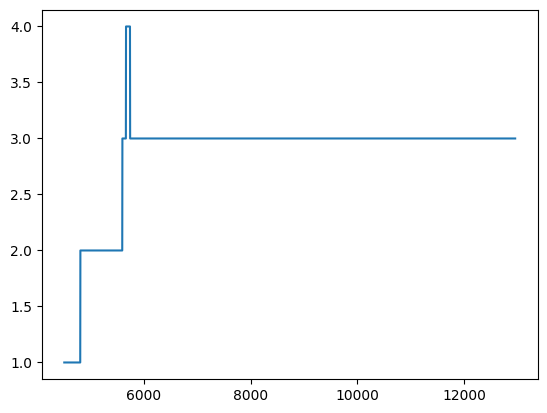

In [ ]:

print(ds_all.event.values)
print(ds_all.time.values.shape)
print(ds_all.ht.shape)
print(ds_all.gt[7,:,3].values)
gt_p,_,_ = parse_gtype(ds_all.gt[7,:,3].values)
print(gt_p)

plt.plot(gt_p)


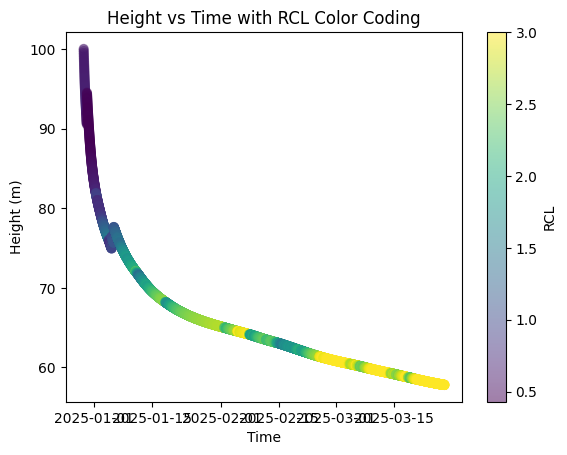

In [8]:

plt.figure
#plot
plt.scatter(ds_all.time.values,ds_all.ht[7,:,3].values,s=40, c=ds_all.rcl[7,:,3].values, cmap='viridis', alpha=0.5)
plt.colorbar(label='RCL')
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.title('Height vs Time with RCL Color Coding')
plt.show()
#plot_seasonal_sn38(ds_all.time.sel(event=7).values,ds_all.sn38.sel(event=7).values)


In [ ]:
import numpy as np

weak_layers_by_event = {}

for event in ds_all.event.values:
    ht = ds_all.ht.sel(event=event)
    rcl = ds_all.rcl.sel(event=event)
    sn38 = ds_all.sn38.sel(event=event)
    gt = ds_all.gt.sel(event=event)
    time = ds_all.time.values

    # Parse primary grain type
    gt_p, _, _ = parse_gtype(gt)  # shape: (time, layer)

    # 1. Create a mask for weak layer candidates (GT 4, 5, 6)
    weak_mask =  ((gt_p == 4) | (gt_p == 5) | (gt_p == 6) | (gt_p == 3) | (gt_p == 2) | (gt_p == 7)) & ((rcl < 0.6) )   # Adjusted to include RCL condition

    # 2. Mask out invalid RCLs or only find where weak layer grain types exist
    rcl_masked = np.where(weak_mask==True, rcl, np.nan)

    # 3. Check if any weak layers exist
    if np.isnan(rcl_masked).all():
        print(f"Event {event}: No valid weak layers (GT=4,5,6)")
        continue

    # 4. Find the (time, layer) index of the minimum RCL from the masked array. This is the layer which has had the lowest RCL value over the entire time series for that event.
    time_idx, layer_idx = np.unravel_index(np.nanargmin(rcl_masked), rcl_masked.shape)

    # 5. Extract the full time series for that layer which is of a weak layer type and has the minimum RCL
    weak_layers_by_event[event] = {
        "rcl": rcl[:, layer_idx].values,
        "ht": ht[:, layer_idx].values,
        "sn38": sn38[:, layer_idx].values,
        "gt": gt_p[:, layer_idx].values,
        "time": time,
        "layer_idx": layer_idx,
        "min_rcl": rcl[time_idx, layer_idx].item()
    }


Event 18: No valid weak layers (GT=4,5,6)
Event 24: No valid weak layers (GT=4,5,6)
Event 25: No valid weak layers (GT=4,5,6)
Event 26: No valid weak layers (GT=4,5,6)
Event 28: No valid weak layers (GT=4,5,6)
Event 30: No valid weak layers (GT=4,5,6)
Event 31: No valid weak layers (GT=4,5,6)
Event 32: No valid weak layers (GT=4,5,6)
Event 33: No valid weak layers (GT=4,5,6)
Event 34: No valid weak layers (GT=4,5,6)
Event 36: No valid weak layers (GT=4,5,6)
Event 38: No valid weak layers (GT=4,5,6)
Event 40: No valid weak layers (GT=4,5,6)
Event 41: No valid weak layers (GT=4,5,6)
Event 43: No valid weak layers (GT=4,5,6)


In [ ]:
print(weak_layers_by_event.keys())
print(weak_layers_by_event.keys())
#print(ds_all.time.values.shape)
# print(ds_all.ht.shape)
#print(ds_all.gt[7,:,3].values)


dict_keys([3, 4, 6, 7, 8, 10, 11, 12, 14, 16, 19, 22, 23, 39, 42])
dict_keys([3, 4, 6, 7, 8, 10, 11, 12, 14, 16, 19, 22, 23, 39, 42])


Event 3: Layer 0 with min RCL 0.26 m
Event 4: Layer 2 with min RCL -999.0 m
Event 6: Layer 1 with min RCL 0.1 m
Event 7: Layer 1 with min RCL -999.0 m
Event 8: Layer 1 with min RCL 0.19 m
Event 10: Layer 0 with min RCL 0.44 m
Event 11: Layer 0 with min RCL 0.21 m
Event 12: Layer 5 with min RCL 0.52 m
Event 14: Layer 0 with min RCL 0.43 m
Event 16: Layer 0 with min RCL 0.58 m
Event 19: Layer 3 with min RCL 0.47 m
Event 22: Layer 2 with min RCL 0.59 m
Event 23: Layer 2 with min RCL 0.42 m
Event 39: Layer 5 with min RCL -999.0 m
Event 42: Layer 0 with min RCL 0.56 m


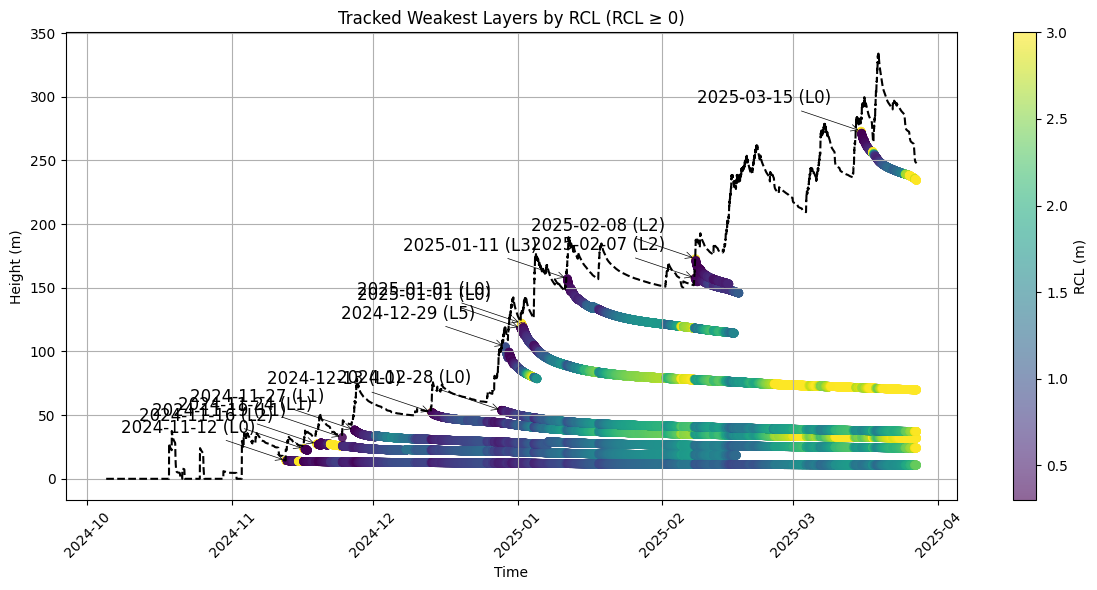

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))

for event, data in weak_layers_by_event.items():
    time = data["time"]                     # shape: (time,)
    rcl = data["rcl"]                       # shape: (time,)
    ht = data["ht"]                         # shape: (time,)
    layer_idx = data["layer_idx"]           # scalar

    print(f"Event {event}: Layer {layer_idx} with min RCL {data['min_rcl']} m")
    # Mask invalid RCL values
    rcl_clean = np.where(rcl >= 0, rcl, np.nan)
    ht_clean = np.where(np.isnan(rcl_clean), np.nan, ht)

    # Scatter plot: time vs height colored by RCL
    sc = plt.scatter(time, ht_clean, c=rcl_clean, cmap='viridis', alpha=0.6, linewidth=0.3)

    # Annotate start date of weak layer
    valid_idx = np.where(~np.isnan(rcl_clean))[0]
    if valid_idx.size > 0:
        start_idx = valid_idx[0]
        start_time = time[start_idx]
        start_ht = ht[start_idx]
        plt.annotate(
            f"{np.datetime_as_string(start_time, unit='D')} (L{layer_idx})",
            (start_time, start_ht),
            textcoords="offset points",
            xytext=(-70, 20),
            ha='center',
            fontsize=12,
            color='black',
            arrowprops=dict(arrowstyle='->', color='black', lw=0.5)
        )

# Optional: overlay HST line (if available)
try:
    plt.plot(vars['dates'], hst, 'k--', label='HST', linewidth=1.5)
except Exception as e:
    print("Warning: Could not plot HST line —", e)

# Final formatting
plt.title("Tracked Weakest Layers by RCL (RCL ≥ 0)")
plt.xlabel("Time")
plt.ylabel("Height (m)")
plt.xticks(rotation=45)
plt.colorbar(sc, label="RCL (m)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
for event, data in weak_layers_by_event.items():
    time = data["time"]                     # shape: (time,)
    rcl = data["rcl"]                       # shape: (time,)
    ht = data["ht"]                         # shape: (time,)
    layer_idx = data["layer_idx"]           # scalar
    gt = data["gt"]                         # shape: (time, layer)

    print(f"Event {event}: Layer {layer_idx} with min RCL {data['min_rcl']} m")
    # Mask invalid RCL values
    rcl_clean = np.where(rcl >= 0, rcl, np.nan)
    ht_clean = np.where(np.isnan(rcl_clean), np.nan, ht)

    # Scatter plot: time vs height colored by RCL
    # Use pcolormesh to plot a mesh colored by gt
    # Prepare meshgrid for time and height
    time_mesh, ht_mesh = np.meshgrid(time, ht_clean)
    gt_mesh = np.tile(gt, (len(ht_clean), 1)).T  # shape: (len(ht_clean), len(time))

    # Plot pcolormesh (transpose so each column is a time step)
    pcm = plt.pcolormesh(time_mesh, ht_mesh, gt_mesh, cmap='tab10', shading='auto', alpha=0.6)
    plt.colorbar(pcm, label='GT')


NameError: name 'weak_layers_by_event' is not defined